# First make the digitization pipeline robust

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from scipy.interpolate import interp1d
import cv2

## Helper functions

In [3]:
mask = cv2.imread('../full-pipeline/data/outputs/1110_6by2_II_binary_wave_plot.png')
img = cv2.imread('../full-pipeline/data/outputs/1110_6by2_II.jpg')

In [4]:
mask.shape

(143, 2383, 3)

In [5]:
img.shape

(143, 2383, 3)

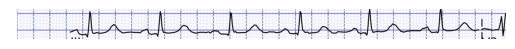

In [6]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [7]:
import sys
sys.path.append('../full-pipeline/scripts')
from grid_detection import get_grid_square_size

square_size = get_grid_square_size(img, closing_kernel=10, length_frac=0.05)
print(square_size)

80


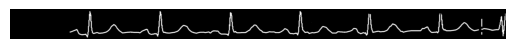

In [8]:
plt.imshow(mask)
plt.axis('off')
plt.show()

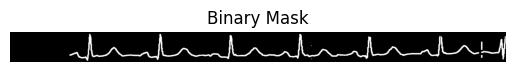

In [9]:
# --- Step 0: Load ECG mask ---
gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

# --- Step 1: Threshold and clean up mask ---
binary_mask = (gray > 0).astype(np.uint8)
plt.imshow(binary_mask, cmap='gray')
plt.title("Binary Mask")
plt.axis('off')
plt.show()

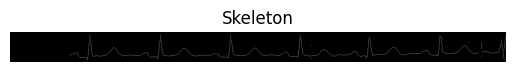

In [10]:

# --- Step 2: Skeletonize mask ---
skeleton = skeletonize(binary_mask.astype(bool)).astype(np.uint8)
plt.imshow(skeleton, cmap='gray')
plt.title("Skeleton")
plt.axis('off')
plt.show()

H, W = skeleton.shape

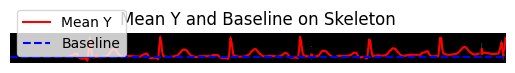

In [11]:

# --- Step 3: Calibration ---
x_pixel_sec = 0.2 / square_size   # seconds per pixel
y_pixel_mV  = 0.5 / square_size   # mV per pixel

# --- Step 4: Get mean y per column ---
y_means = np.full(W, np.nan)
all_y_indices = []

for x in range(W):
    y_indices = np.where(skeleton[:, x] > 0)[0]
    if len(y_indices) > 0:
        y_means[x] = y_indices.mean()
        all_y_indices.extend(y_indices.tolist())

# --- Step 5: Estimate baseline using mode ---
counts = np.bincount(all_y_indices, minlength=H)
baseline_y = int(np.argmax(counts))

# Plot mean y and baseline
plt.imshow(skeleton, cmap='gray')
plt.plot(np.arange(W), y_means, color='red', label='Mean Y')
plt.axhline(baseline_y, color='blue', linestyle='--', label='Baseline')
plt.title("Mean Y and Baseline on Skeleton")
plt.legend()
plt.axis('off')
plt.show()


In [12]:
y_means.shape

(2383,)

In [13]:
import numpy as np

def trim_signal_edges(signal, threshold=1e-4):
    signal = np.array(signal)

    # Convert NaNs to 0 temporarily for zero thresholding
    valid_mask = ~np.isnan(signal) & (np.abs(signal) > threshold)

    if not np.any(valid_mask):
        return np.array([])  # All values are invalid

    start = np.argmax(valid_mask)
    end = len(signal) - np.argmax(valid_mask[::-1])

    return signal[start:end]


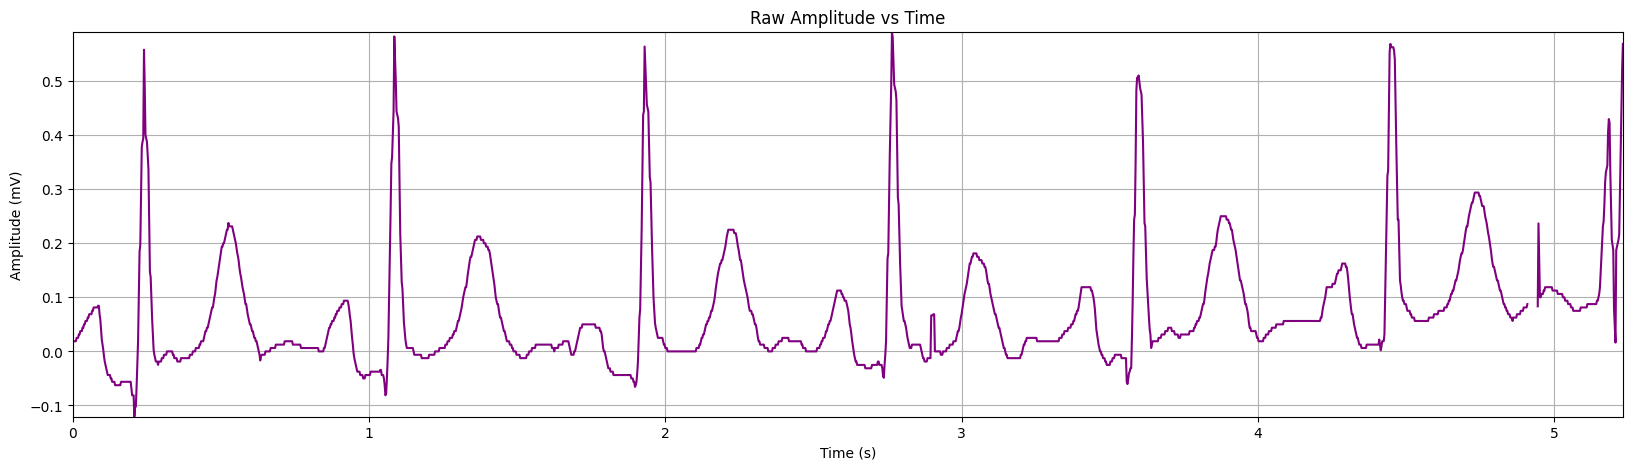

In [14]:

# --- Step 6: Amplitude and Time ---
amplitude_mv = trim_signal_edges((baseline_y - y_means) * y_pixel_mV)
time = np.arange(len(amplitude_mv)) * x_pixel_sec


plt.figure(figsize=(20, 5))
plt.plot(time, amplitude_mv, color='purple')
plt.title("Raw Amplitude vs Time")
plt.xlabel("Time (s)")
plt.xlim(0, time[-1])
plt.ylim(min(amplitude_mv), max(amplitude_mv))
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()

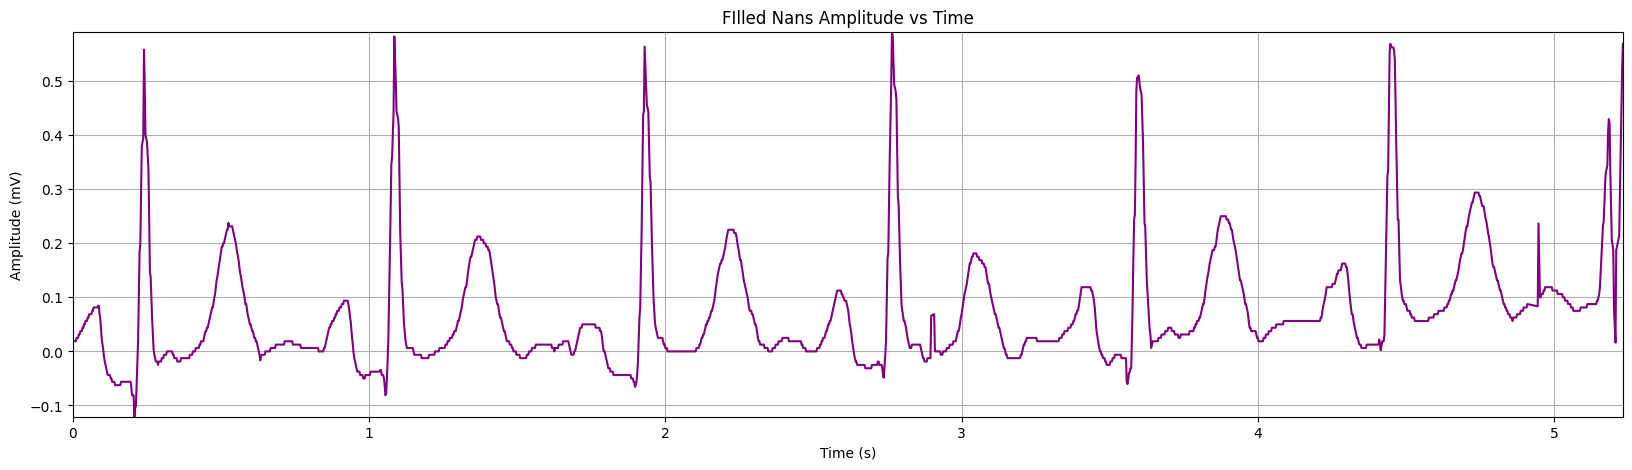

In [15]:
from pandas import Series

amplitude_filled = Series(amplitude_mv).interpolate(method='linear', limit_direction='both').to_numpy()


plt.figure(figsize=(20, 5))
plt.plot(time, amplitude_filled, color='purple')
plt.title("FIlled Nans Amplitude vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.xlim(0, time[-1])
plt.ylim(min(amplitude_filled), max(amplitude_filled))
plt.grid(True)
plt.show()

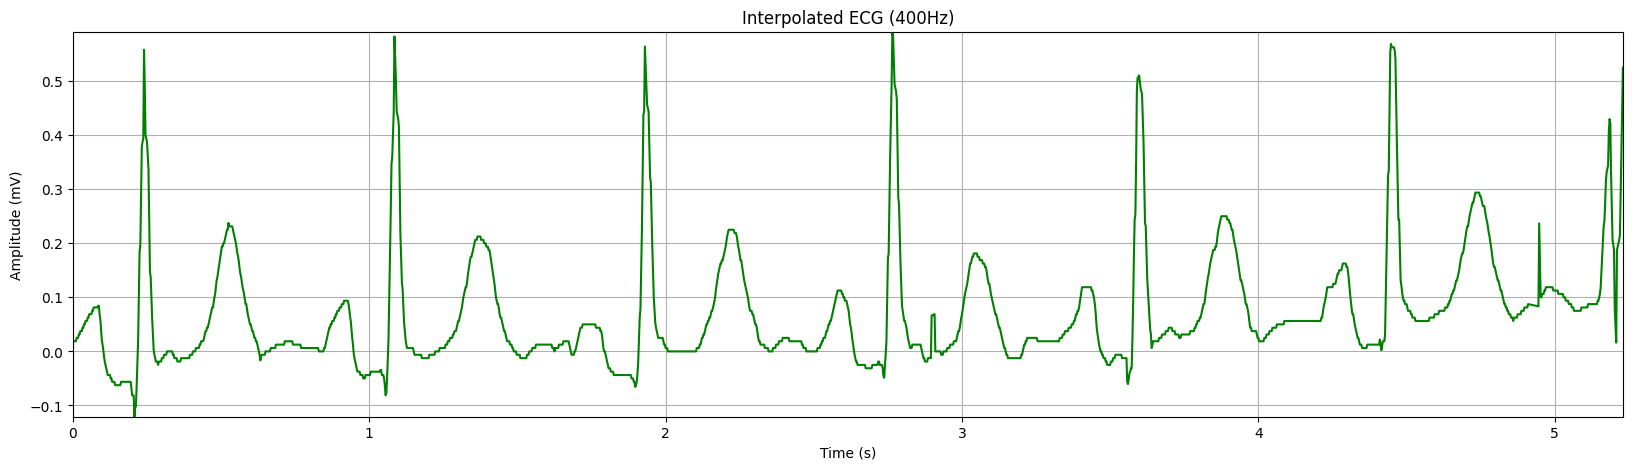

In [16]:

# --- Step 7: Interpolate to 400Hz ---
valid = ~np.isnan(amplitude_filled)
interp_func = interp1d(time[valid], amplitude_filled[valid], kind='linear', bounds_error=False)
time_interp = np.arange(0, time[-1], 0.0025)
signal_mv_interp = interp_func(time_interp)

plt.figure(figsize=(20,5))
plt.plot(time_interp, signal_mv_interp, color='green')
plt.title("Interpolated ECG (400Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.xlim(0, time_interp[-1])
plt.ylim(min(signal_mv_interp), max(signal_mv_interp))
plt.grid(True)
plt.show()


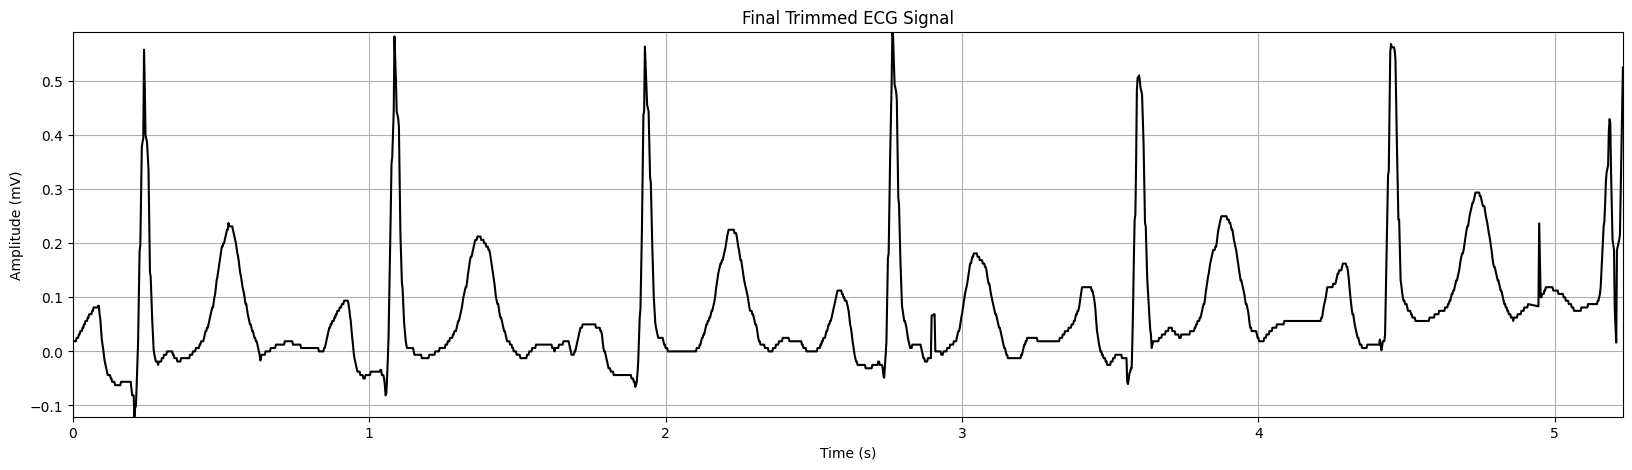

In [17]:

# --- Step 8: Trim trailing zeros ---
non_zero_indices = np.where(np.abs(signal_mv_interp) > 1e-4)[0]
last_nonzero_idx = non_zero_indices[-1]
signal_mv_interp = signal_mv_interp[:last_nonzero_idx + 1]
time_interp = time_interp[:last_nonzero_idx + 1]

plt.figure(figsize=(20,5))
plt.plot(time_interp, signal_mv_interp, color='black')
plt.title("Final Trimmed ECG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.xlim(0, time_interp[-1])
plt.ylim(min(signal_mv_interp), max(signal_mv_interp))
plt.grid(True)
plt.show()


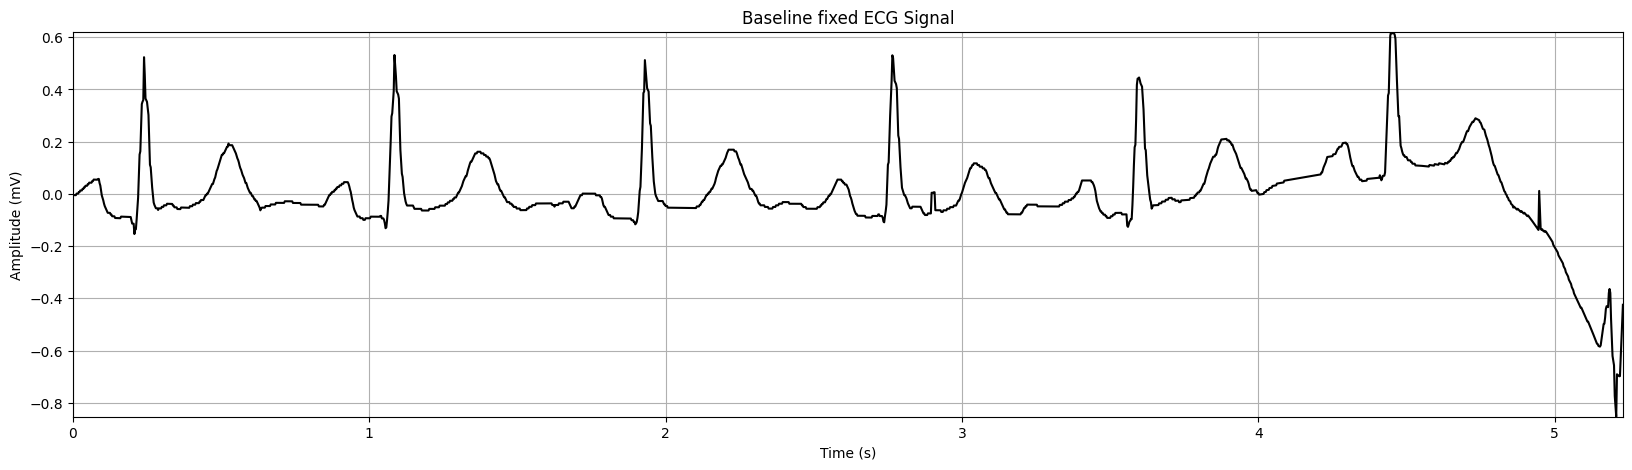

In [18]:
from scipy.signal import butter, filtfilt

def highpass_filter(signal, fs, cutoff=0.5, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered = filtfilt(b, a, signal)
    return filtered

signal_hp = highpass_filter(signal_mv_interp, fs=400)


plt.figure(figsize=(20,5))
plt.plot(time_interp, signal_hp, color='black')
plt.title("Baseline fixed ECG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.xlim(0, time_interp[-1])
plt.ylim(min(signal_hp), max(signal_hp))
plt.grid(True)
plt.show()


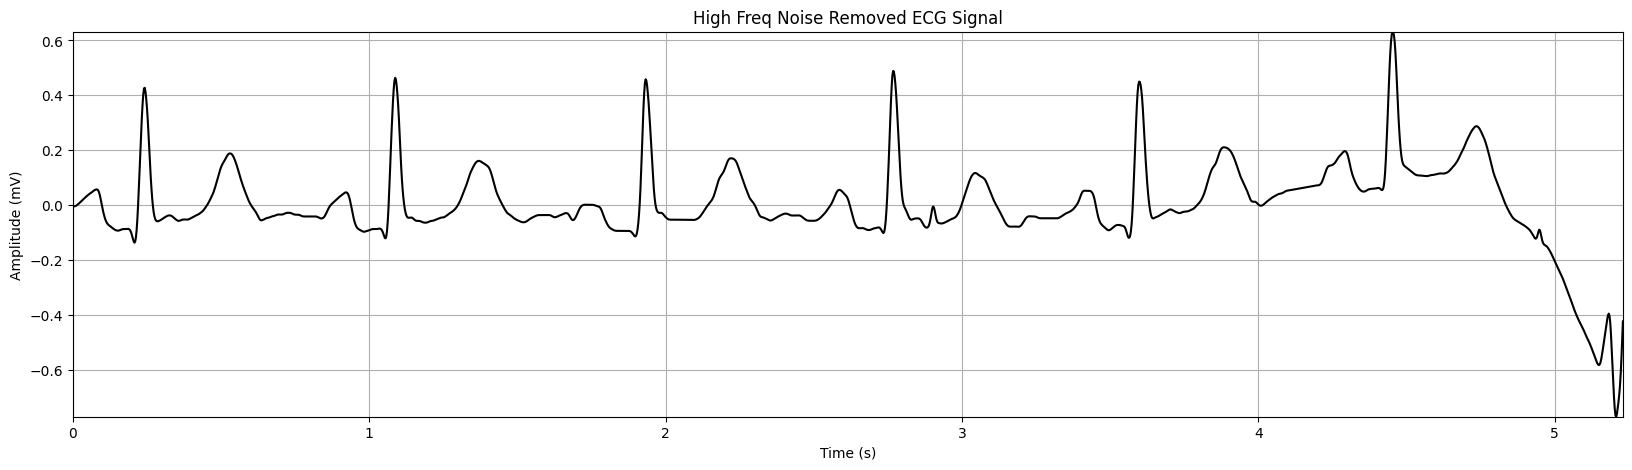

In [19]:
def lowpass_filter(signal, fs, cutoff=40.0, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered = filtfilt(b, a, signal)
    return filtered
signal_filtered = lowpass_filter(signal_hp, fs=400)

plt.figure(figsize=(20,5))
plt.plot(time_interp, signal_filtered, color='black')
plt.title("High Freq Noise Removed ECG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.xlim(0, time_interp[-1])
plt.ylim(min(signal_filtered), max(signal_filtered))
plt.grid(True)
plt.show()

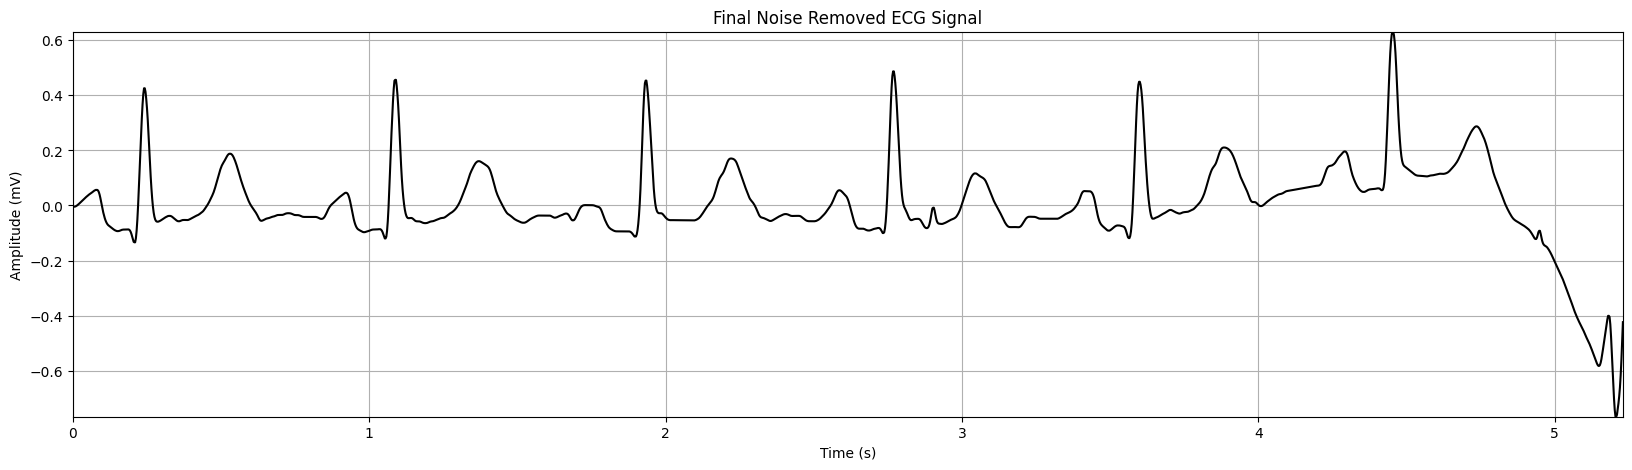

In [20]:
from scipy.signal import medfilt

signal_clean = medfilt(signal_filtered, kernel_size=3)

plt.figure(figsize=(20,5))
plt.plot(time_interp, signal_clean, color='black')
plt.title("Final Noise Removed ECG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.xlim(0, time_interp[-1])
plt.ylim(min(signal_clean), max(signal_clean))
plt.grid(True)
plt.show()

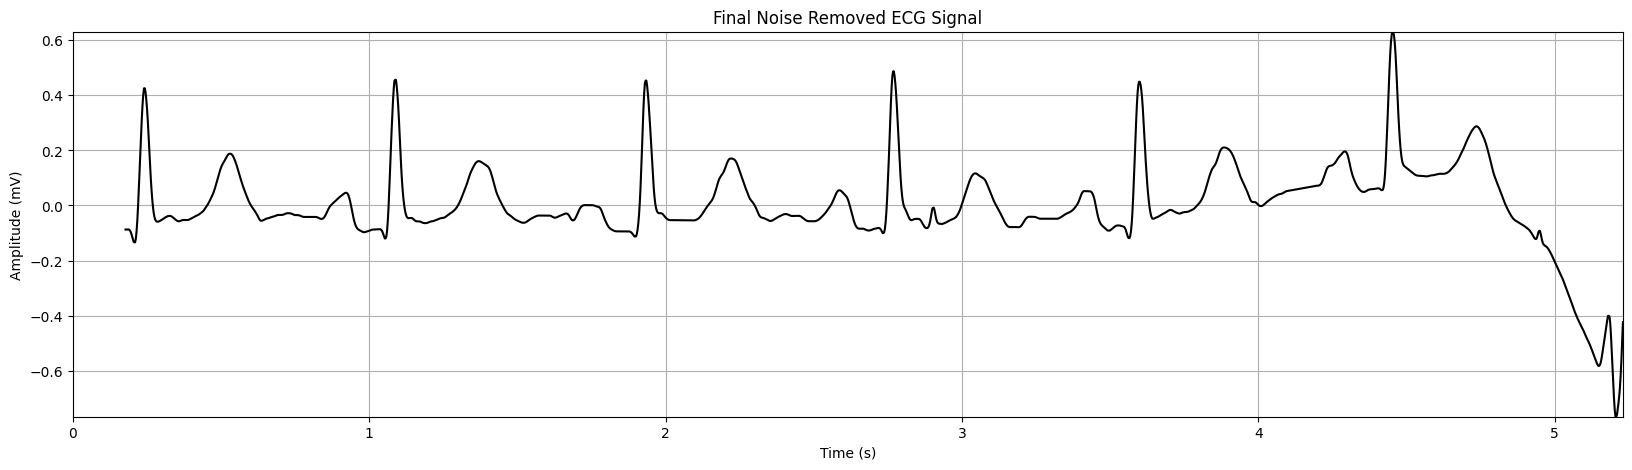

In [21]:
import numpy as np
import numpy as np

def trim_low_energy_and_spikes(signal, time=None, threshold_ratio=0.05, window_size=50, spike_threshold=5.0):
    # Step 1: Compute energy
    energy = np.convolve(signal**2, np.ones(window_size), mode='same')
    max_energy = np.max(energy)
    threshold = threshold_ratio * max_energy

    # Step 2: Find indices where energy is meaningful
    nonzero_indices = np.where(energy > threshold)[0]
    if len(nonzero_indices) == 0:
        return signal, time  # fallback if all energy is low

    start_idx = nonzero_indices[0]
    end_idx = nonzero_indices[-1]

    # Step 3: Trim based on energy
    signal_trimmed = signal[start_idx:end_idx + 1]
    time_trimmed = time[start_idx:end_idx + 1] if time is not None else None

    # Step 4: Compute derivative to detect spikes
    diff = np.diff(signal_trimmed)
    spike_indices = np.where(np.abs(diff) > spike_threshold)[0]

    # Step 5: Remove leading/trailing spikes
    for idx in spike_indices:
        if idx < len(signal_trimmed) * 0.05:  # spike near start
            signal_trimmed = signal_trimmed[idx+1:]
            if time_trimmed is not None:
                time_trimmed = time_trimmed[idx+1:]
        elif idx > len(signal_trimmed) * 0.95:  # spike near end
            signal_trimmed = signal_trimmed[:idx]
            if time_trimmed is not None:
                time_trimmed = time_trimmed[:idx]

    return signal_trimmed, time_trimmed

signal_trimmed, time_trimmed = trim_low_energy_and_spikes(signal_clean, time)

plt.figure(figsize=(20,5))
plt.plot(time_trimmed, signal_trimmed, color='black')
plt.title("Final Noise Removed ECG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.xlim(0, time_trimmed[-1])
plt.ylim(min(signal_trimmed), max(signal_trimmed))
plt.grid(True)
plt.show()


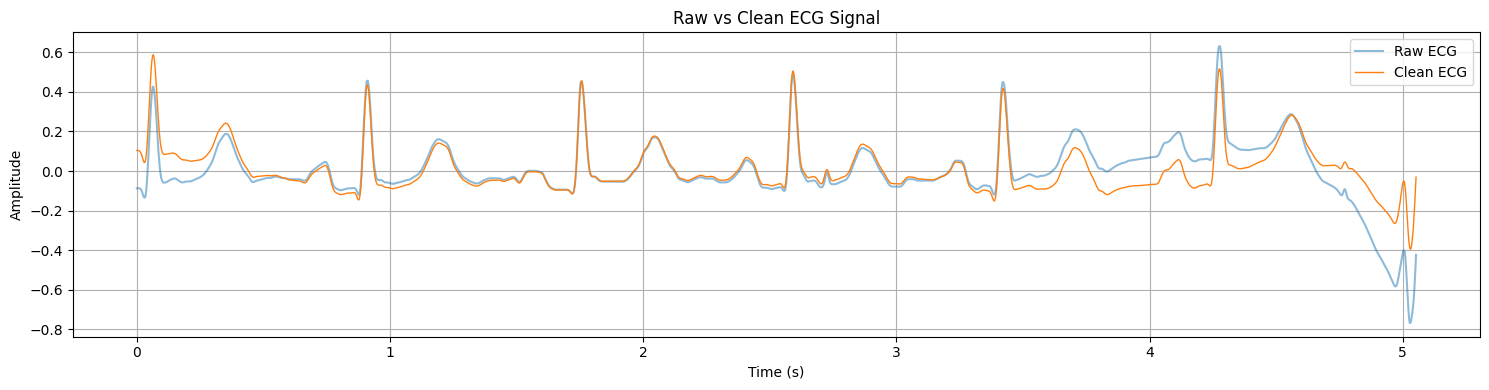

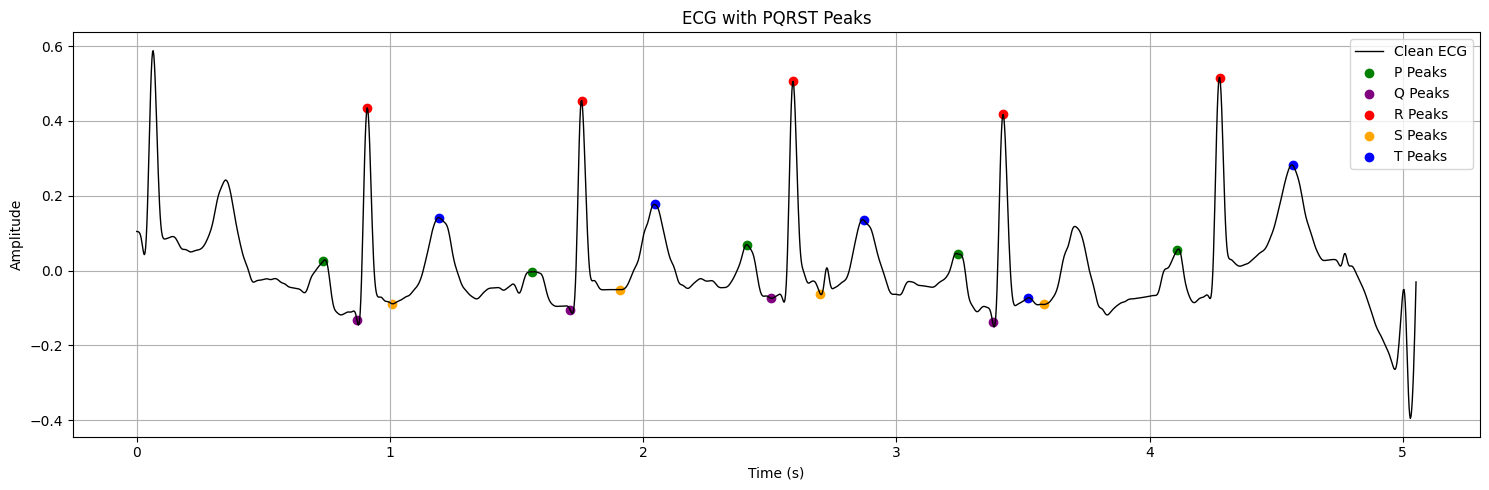

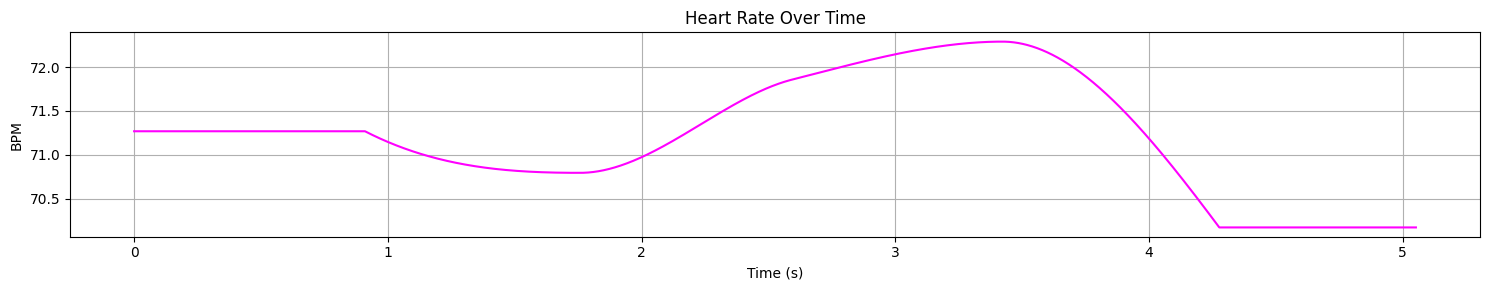

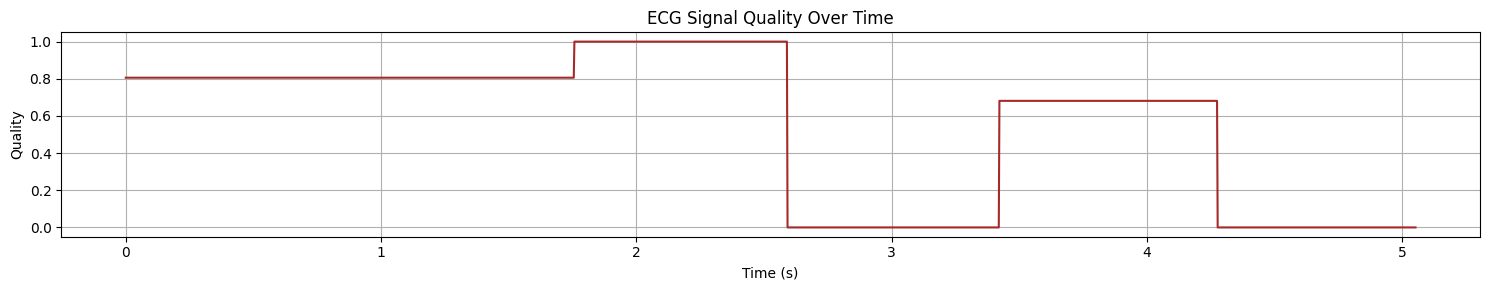

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
from scipy.signal import butter, filtfilt


def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=400, order=3):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, signal)

# Process the ECG signal
ecg_signals, info = nk.ecg_process(signal_trimmed, sampling_rate=400)


ecg_signals['ECG_Clean'] = bandpass_filter(ecg_signals['ECG_Raw'], fs=400)

# Sampling and time axis
sampling_rate = 400
time = np.arange(len(ecg_signals)) / sampling_rate

# 1. Raw vs Clean ECG
plt.figure(figsize=(15, 4))
plt.plot(time, ecg_signals['ECG_Raw'], label='Raw ECG', alpha=0.5)
plt.plot(time, ecg_signals['ECG_Clean'], label='Clean ECG', linewidth=1)
plt.title("Raw vs Clean ECG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Clean ECG with PQRST markers
plt.figure(figsize=(15, 5))
plt.plot(time, ecg_signals["ECG_Clean"], label="Clean ECG", color='black', linewidth=1)

peak_colors = {
    'ECG_P_Peaks': 'green',
    'ECG_Q_Peaks': 'purple',
    'ECG_R_Peaks': 'red',
    'ECG_S_Peaks': 'orange',
    'ECG_T_Peaks': 'blue'
}

for peak_name, color in peak_colors.items():
    peaks = info.get(peak_name, [])
    if peaks is not None and len(peaks) > 0:
        peaks = np.array(peaks)
        # Keep only valid indices
        valid_peaks = peaks[(peaks >= 0) & (peaks < len(ecg_signals))]
        plt.scatter(valid_peaks / sampling_rate,
                    ecg_signals["ECG_Clean"].iloc[valid_peaks],
                    label=peak_name.replace("ECG_", "").replace("_", " "),
                    color=color)

plt.title("ECG with PQRST Peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Heart Rate Over Time
plt.figure(figsize=(15, 3))
plt.plot(time, ecg_signals["ECG_Rate"], label="Heart Rate (BPM)", color="magenta")
plt.title("Heart Rate Over Time")
plt.xlabel("Time (s)")
plt.ylabel("BPM")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Signal Quality Over Time
plt.figure(figsize=(15, 3))
plt.plot(time, ecg_signals["ECG_Quality"], label="ECG Signal Quality", color="brown")
plt.title("ECG Signal Quality Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Quality")
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
ecg_signals.columns

Index(['ECG_Raw', 'ECG_Clean', 'ECG_Rate', 'ECG_Quality', 'ECG_R_Peaks',
       'ECG_P_Peaks', 'ECG_P_Onsets', 'ECG_P_Offsets', 'ECG_Q_Peaks',
       'ECG_R_Onsets', 'ECG_R_Offsets', 'ECG_S_Peaks', 'ECG_T_Peaks',
       'ECG_T_Onsets', 'ECG_T_Offsets', 'ECG_Phase_Atrial',
       'ECG_Phase_Completion_Atrial', 'ECG_Phase_Ventricular',
       'ECG_Phase_Completion_Ventricular'],
      dtype='object')

Longest high-quality segment: Start=0, End=1037, Length=1037


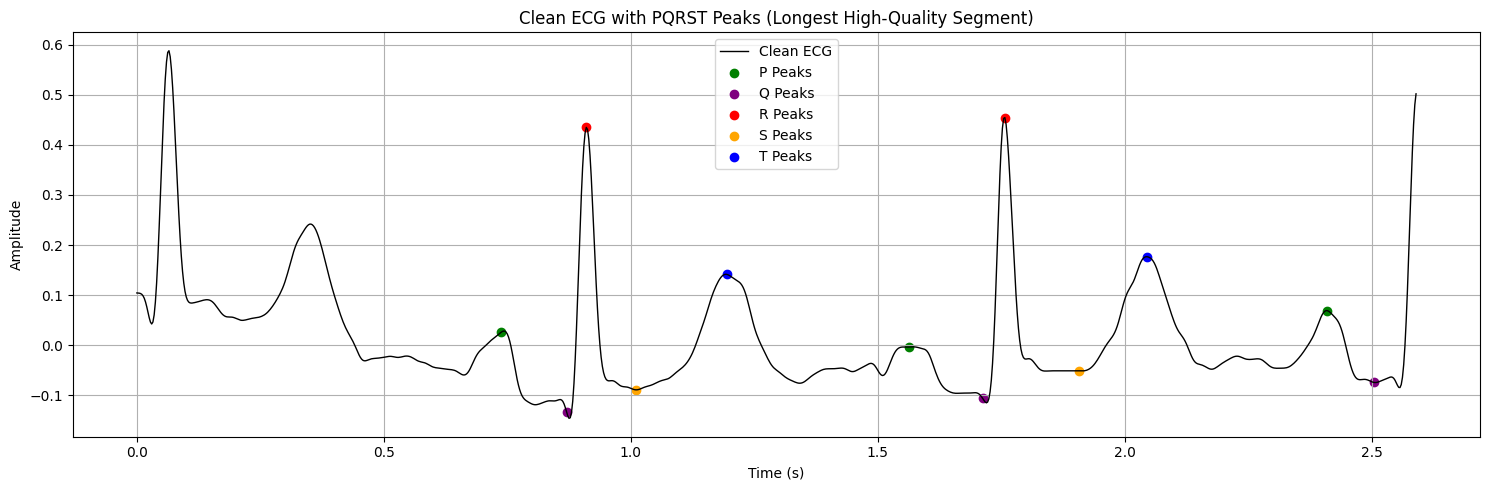

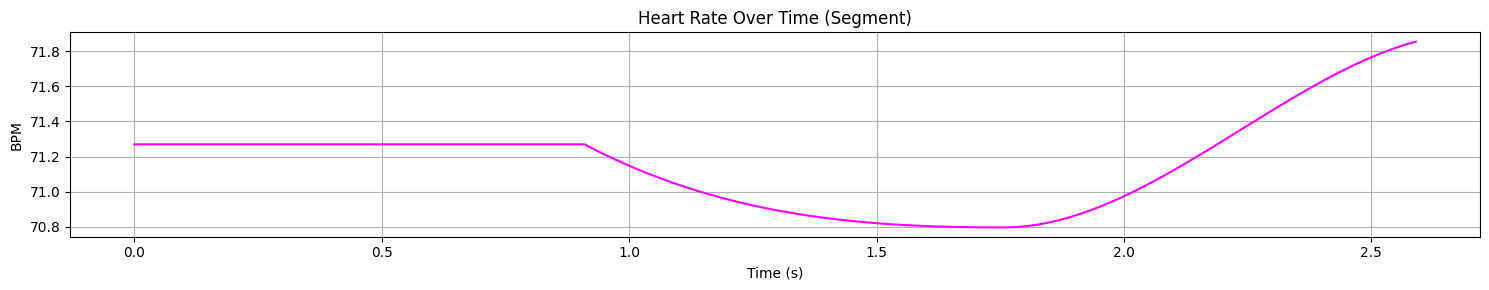

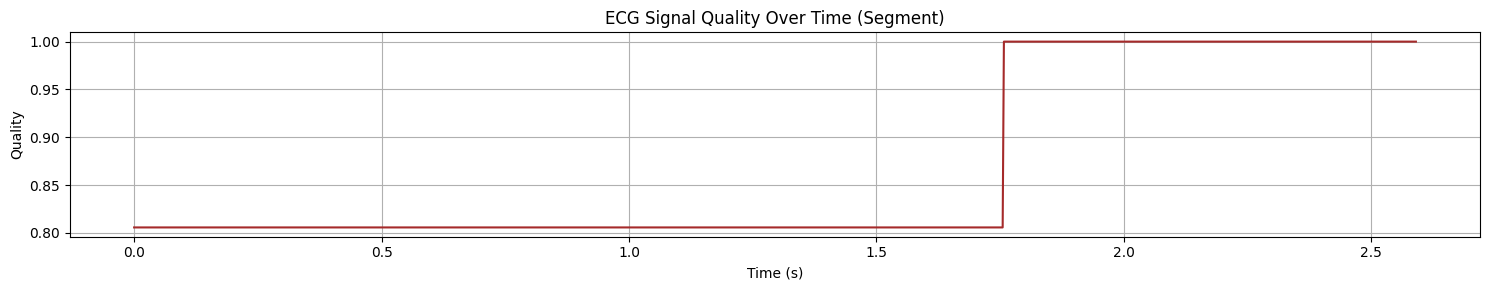

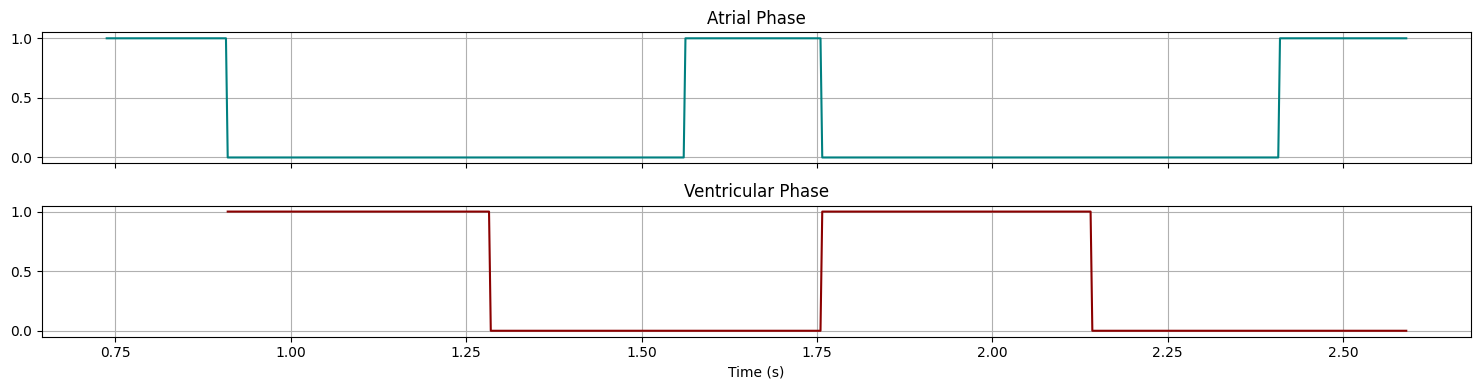

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk

# 1. Find longest high-quality segment
quality_mask = ecg_signals["ECG_Quality"] >= 0.5
diffs = np.diff(quality_mask.astype(int))
starts = np.where(diffs == 1)[0] + 1
ends = np.where(diffs == -1)[0] + 1

if quality_mask.iloc[0]:
    starts = np.insert(starts, 0, 0)
if quality_mask.iloc[-1]:
    ends = np.append(ends, len(quality_mask))

lengths = ends - starts
if len(lengths) == 0:
    raise ValueError("No segment found with ECG_Quality >= 0.5")

longest_idx = np.argmax(lengths)
start_idx = starts[longest_idx]
end_idx = ends[longest_idx]

segment = ecg_signals.iloc[start_idx:end_idx].reset_index(drop=True)
segment_time = np.arange(len(segment)) / sampling_rate

print(f"Longest high-quality segment: Start={start_idx}, End={end_idx}, Length={end_idx - start_idx}")

# 2. Plot Clean ECG with PQRST
plt.figure(figsize=(15, 5))
plt.plot(segment_time, segment["ECG_Clean"], label="Clean ECG", color="black", linewidth=1)

# Plot PQRST Peaks
peak_colors = {
    'ECG_P_Peaks': 'green',
    'ECG_Q_Peaks': 'purple',
    'ECG_R_Peaks': 'red',
    'ECG_S_Peaks': 'orange',
    'ECG_T_Peaks': 'blue'
}
for peak_name, color in peak_colors.items():
    if peak_name in info:
        peaks = np.array(info[peak_name])
        # Only keep peaks within the segment
        peaks_in_segment = [p - start_idx for p in peaks if start_idx <= p < end_idx]
        if len(peaks_in_segment) > 0:
            plt.scatter(np.array(peaks_in_segment) / sampling_rate,
                        segment["ECG_Clean"].iloc[peaks_in_segment],
                        color=color, label=peak_name.replace("ECG_", "").replace("_", " "))

plt.title("Clean ECG with PQRST Peaks (Longest High-Quality Segment)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 3. Heart Rate
plt.figure(figsize=(15, 3))
plt.plot(segment_time, segment["ECG_Rate"], color="magenta", label="Heart Rate (BPM)")
plt.title("Heart Rate Over Time (Segment)")
plt.xlabel("Time (s)")
plt.ylabel("BPM")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Signal Quality
plt.figure(figsize=(15, 3))
plt.plot(segment_time, segment["ECG_Quality"], color="brown", label="Signal Quality")
plt.title("ECG Signal Quality Over Time (Segment)")
plt.xlabel("Time (s)")
plt.ylabel("Quality")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. ECG Phases
if "ECG_Phase_Atrial" in segment.columns and "ECG_Phase_Ventricular" in segment.columns:
    fig, axs = plt.subplots(2, 1, figsize=(15, 4), sharex=True)

    axs[0].plot(segment_time, segment["ECG_Phase_Atrial"], label="Atrial Phase", color="teal")
    axs[0].set_title("Atrial Phase")
    axs[0].grid(True)

    axs[1].plot(segment_time, segment["ECG_Phase_Ventricular"], label="Ventricular Phase", color="darkred")
    axs[1].set_title("Ventricular Phase")
    axs[1].set_xlabel("Time (s)")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("ECG Phases not found in segment.")


In [25]:
def extract_avg_ecg_features(segment: pd.DataFrame, sampling_rate: int = 500):
    def duration(start, end):
        return (end - start) / sampling_rate if (start >= 0 and end >= 0) else np.nan

    # Find index positions of each wave peak
    r_peaks = segment.index[segment["ECG_R_Peaks"] == 1].tolist()
    p_peaks = segment.index[segment["ECG_P_Peaks"] == 1]
    q_peaks = segment.index[segment["ECG_Q_Peaks"] == 1]
    s_peaks = segment.index[segment["ECG_S_Peaks"] == 1]
    t_peaks = segment.index[segment["ECG_T_Peaks"] == 1]

    # Feature storage
    feature_list = {
        "RR_Interval_s": [],
        "Heart_Rate_BPM": [],
        "P_Amplitude": [],
        "Q_Amplitude": [],
        "R_Amplitude": [],
        "S_Amplitude": [],
        "T_Amplitude": [],
        "PR_Interval_s": [],
        "QRS_Duration_s": [],
        "QT_Interval_s": [],
    }

    for i in range(len(r_peaks) - 1):
        try:
            r1 = r_peaks[i]
            r2 = r_peaks[i + 1]

            rr_interval = duration(r1, r2)
            heart_rate = 60 / rr_interval if rr_interval > 0 else np.nan

            p_peak = p_peaks[p_peaks < r1].max()
            q_peak = q_peaks[(q_peaks > p_peak) & (q_peaks < r1)].min()
            s_peak = s_peaks[(s_peaks > r1) & (s_peaks < r2)].min()
            t_peak = t_peaks[(t_peaks > s_peak) & (t_peaks < r2)].min()

            # Amplitudes
            r_amp = segment.loc[r1, "ECG_Clean"]
            p_amp = segment.loc[p_peak, "ECG_Clean"] if not np.isnan(p_peak) else np.nan
            q_amp = segment.loc[q_peak, "ECG_Clean"] if not np.isnan(q_peak) else np.nan
            s_amp = segment.loc[s_peak, "ECG_Clean"] if not np.isnan(s_peak) else np.nan
            t_amp = segment.loc[t_peak, "ECG_Clean"] if not np.isnan(t_peak) else np.nan

            # Durations
            pr_interval = duration(p_peak, r1)
            qrs_duration = duration(q_peak, s_peak)
            qt_interval = duration(q_peak, t_peak)

            feature_list["RR_Interval_s"].append(rr_interval)
            feature_list["Heart_Rate_BPM"].append(heart_rate)
            feature_list["P_Amplitude"].append(p_amp)
            feature_list["Q_Amplitude"].append(q_amp)
            feature_list["R_Amplitude"].append(r_amp)
            feature_list["S_Amplitude"].append(s_amp)
            feature_list["T_Amplitude"].append(t_amp)
            feature_list["PR_Interval_s"].append(pr_interval)
            feature_list["QRS_Duration_s"].append(qrs_duration)
            feature_list["QT_Interval_s"].append(qt_interval)

        except Exception as e:
            print(f"Skipped beat {i} due to error: {e}")
            continue

    # Compute average across all beats
    avg_features = {k: np.nanmean(v) for k, v in feature_list.items()}
    return pd.Series(avg_features)


NameError: name 'pd' is not defined

In [ ]:
features_df = extract_avg_ecg_features(segment)

In [ ]:
features_df.head()

RR_Interval_s      0.678000
Heart_Rate_BPM    88.495575
P_Amplitude        0.025848
Q_Amplitude       -0.132844
R_Amplitude        0.434737
dtype: float64

In [ ]:
segment

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,-0.087322,0.104361,71.269488,0.80581,0,0,0,0,0,0,0,0,0,0,0,NaN,0.000000,NaN,0.000000
1,-0.087166,0.104200,71.269488,0.80581,0,0,0,0,0,0,0,0,0,0,0,NaN,0.000000,NaN,0.000000
2,-0.086912,0.103883,71.269488,0.80581,0,0,0,0,0,0,0,0,0,0,0,NaN,0.000000,NaN,0.000000
3,-0.086912,0.103154,71.269488,0.80581,0,0,0,0,0,0,0,0,0,0,0,NaN,0.000000,NaN,0.000000
4,-0.086913,0.101587,71.269488,0.80581,0,0,0,0,0,0,0,0,0,0,0,NaN,0.000000,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,0.300136,0.320115,71.846610,1.00000,0,0,0,0,0,0,0,0,0,0,0,1.0,0.944444,0.0,0.977654
1033,0.370459,0.385768,71.848615,1.00000,0,0,0,0,0,0,0,0,0,0,0,1.0,0.958333,0.0,0.983240
1034,0.429471,0.440279,71.850586,1.00000,0,0,0,0,0,0,0,0,0,0,0,1.0,0.972222,0.0,0.988827
1035,0.470187,0.479680,71.852522,1.00000,0,0,0,0,0,0,0,0,0,0,0,1.0,0.986111,0.0,0.994413


In [ ]:
print(segment["ECG_Clean"].min(), segment["ECG_Clean"].max())


-0.14585986873181062 0.587690484240329


In [ ]:
print("ECG_Raw range:", ecg_signals["ECG_Raw"].min(), ecg_signals["ECG_Raw"].max())
print("ECG_Clean range:", ecg_signals["ECG_Clean"].min(), ecg_signals["ECG_Clean"].max())


ECG_Raw range: -0.7668860478629 0.6309184765548715
ECG_Clean range: -0.3952734269428034 0.587690484240329


In [26]:
segment

,ECG_Raw,ECG_Clean,ECG_Rate,ECG_Quality,ECG_R_Peaks,ECG_P_Peaks,ECG_P_Onsets,ECG_P_Offsets,ECG_Q_Peaks,ECG_R_Onsets,ECG_R_Offsets,ECG_S_Peaks,ECG_T_Peaks,ECG_T_Onsets,ECG_T_Offsets,ECG_Phase_Atrial,ECG_Phase_Completion_Atrial,ECG_Phase_Ventricular,ECG_Phase_Completion_Ventricular
0,-0.087322,0.104361,71.269488,0.80581,0,0,0,0,0,0,0,0,0,0,0,NaN,0.000000,NaN,0.000000
1,-0.087166,0.104200,71.269488,0.80581,0,0,0,0,0,0,0,0,0,0,0,NaN,0.000000,NaN,0.000000
2,-0.086912,0.103883,71.269488,0.80581,0,0,0,0,0,0,0,0,0,0,0,NaN,0.000000,NaN,0.000000
3,-0.086912,0.103154,71.269488,0.80581,0,0,0,0,0,0,0,0,0,0,0,NaN,0.000000,NaN,0.000000
4,-0.086913,0.101587,71.269488,0.80581,0,0,0,0,0,0,0,0,0,0,0,NaN,0.000000,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032,0.300136,0.320115,71.846610,1.00000,0,0,0,0,0,0,0,0,0,0,0,1.0,0.944444,0.0,0.977654
1033,0.370459,0.385768,71.848615,1.00000,0,0,0,0,0,0,0,0,0,0,0,1.0,0.958333,0.0,0.983240
1034,0.429471,0.440279,71.850586,1.00000,0,0,0,0,0,0,0,0,0,0,0,1.0,0.972222,0.0,0.988827
1035,0.470187,0.479680,71.852522,1.00000,0,0,0,0,0,0,0,0,0,0,0,1.0,0.986111,0.0,0.994413


In [28]:
info

{'method_peaks': 'neurokit',
 'method_fixpeaks': 'None',
 'ECG_R_Peaks': array([ 364,  703, 1037, 1369, 1711]),
 'ECG_R_Peaks_Uncorrected': array([ 364,  703, 1037, 1369, 1711]),
 'ECG_fixpeaks_ectopic': [],
 'ECG_fixpeaks_missed': [],
 'ECG_fixpeaks_extra': [],
 'ECG_fixpeaks_longshort': [],
 'ECG_fixpeaks_method': 'kubios',
 'ECG_fixpeaks_rr': array([0.841875, 0.8475  , 0.835   , 0.83    , 0.855   ]),
 'ECG_fixpeaks_drrs': array([ 0.16826923,  0.28846154, -0.64102564, -0.25641026,  1.28205128]),
 'ECG_fixpeaks_mrrs': array([ 0.        ,  0.26627219, -0.65088757, -1.12426036,  0.62130178]),
 'ECG_fixpeaks_s12': array([ 0.28846154,  0.16826923, -0.25641026, -0.64102564, -0.25641026]),
 'ECG_fixpeaks_s22': array([-0.64102564, -0.64102564,  1.28205128,  1.28205128, -0.64102564]),
 'ECG_fixpeaks_c1': 0.13,
 'ECG_fixpeaks_c2': 0.17,
 'sampling_rate': 400,
 'ECG_P_Peaks': [295, 625, 964, 1297, 1644],
 'ECG_P_Onsets': [266, 605, 936, 1277, 1610],
 'ECG_P_Offsets': [314, 655, 988, 1319, 1665]